In [1]:
import torch
if torch.cuda.is_available(): 
    print(f"{torch.cuda.device_count()} GPUs available.")
import torch.nn.functional as F
import torch_geometric
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import networkx as nx
from glob import glob
import numpy as np
from livelossplot import PlotLosses
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.rc('text', usetex=False)
plt.rc('font', family='serif')

# ### Set seeds for reproducibility
#seed = 15
#torch.manual_seed(seed)
#torch.cuda.manual_seed(seed)
#np.random.seed(seed)sq
#import random
#random.seed(seed)

4 GPUs available.


## Test workflow on a single stream

In [2]:
def create_subset(df): 
    # Fit a line to the subset using linear regression
    from sklearn.linear_model import LinearRegression
    model = LinearRegression()
    stream_ϕ = df[df.stream]['ϕ'].values.reshape(-1, 1)
    stream_λ = df[df.stream]['λ'].values
    model.fit(stream_ϕ, stream_λ)
    
    # Get the slope and intercept of the fitted line
    slope = model.coef_[0]
    intercept = model.intercept_
    
    # Function to calculate perpendicular distance from a point to a line
    def distance_to_line(x, y, slope, intercept):
        return abs(slope * x - y + intercept) / np.sqrt(slope**2 + 1)
    
    # Define the distance threshold
    max_star_distance = np.max(distance_to_line(df[df.stream]['ϕ'].values, df[df.stream]['λ'].values, slope, intercept))
    radius = np.max([2.0, max_star_distance])
    
    # Calculate distances of all points to the fitted line
    distances = distance_to_line(df['ϕ'].values, df['λ'].values, slope, intercept)
    
    # Select points within the distance threshold
    selected_points = df[distances <= radius]

    return selected_points 

In [3]:
mock_streams = sorted(glob("/global/cfs/cdirs/m3246/mpettee/misc/GaiaCWoLa/gaia_data/mock_streams/*.npy"))

In [4]:
df = pd.DataFrame(np.load(mock_streams[1]), columns = ["μ_δ", "μ_α", "δ", "α", "b-r", "g", "ϕ", "λ", "μ_ϕcosλ", "μ_λ", 'stream'])
df['α'] = df['α'].apply(lambda x: x if x > 100 else x + 360)
df['stream'] = df['stream']/100
df['stream'] = df['stream'].astype(bool)
df = df[["ϕ", "λ", "μ_ϕcosλ", "μ_λ", 'b-r', 'g', 'stream']]
df

,ϕ,λ,μ_ϕcosλ,μ_λ,b-r,g,stream
0,8.841160,0.281291,-2.098208,-11.830484,0.966099,18.886600,False
1,8.812834,0.271012,-26.632043,-3.845377,1.419800,17.494600,False
2,8.798531,0.270310,-0.265391,-0.519287,1.229799,17.822701,False
3,8.787544,0.268140,4.488552,-16.140514,0.819900,14.634200,False
4,8.769486,0.245202,0.064643,-7.381773,0.758999,18.575701,False
...,...,...,...,...,...,...,...
885949,9.701814,-8.415374,-5.356374,3.408764,0.772000,18.517589,True
885950,7.269528,-4.284956,-4.991119,3.472365,0.758815,20.014007,True
885951,7.402676,-4.235314,-6.069681,2.951818,1.107232,20.395196,True
885952,-3.146522,13.198069,-5.180129,3.590902,0.768548,19.551535,True


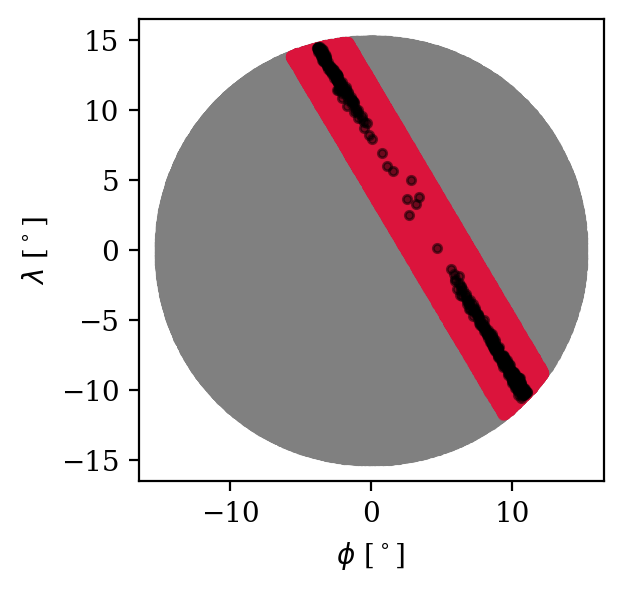

In [5]:
selected_points = create_subset(df)

plt.figure(dpi=200, figsize=(3,3))
plt.scatter(df[~df.stream]['ϕ'], df[~df.stream]['λ'], color='grey', alpha=0.5, marker=".");
plt.scatter(selected_points['ϕ'], selected_points['λ'], color='crimson', alpha=0.5, marker=".");
plt.scatter(df[df.stream]['ϕ'], df[df.stream]['λ'], color='black', alpha=0.5, marker=".");
plt.xlabel(r"$\phi$ [$^\circ$]")
plt.ylabel(r"$\lambda$ [$^\circ$]");

In [6]:
selected_points.stream.value_counts()

stream
False    139117
True        438
Name: count, dtype: int64

In [7]:
from sklearn.neighbors import NearestNeighbors
import torch
from torch_geometric.data import Data
from sklearn.neighbors import NearestNeighbors

def create_mock_stream_graph(file, k=0):
    df = pd.DataFrame(np.load(file), columns = ["μ_δ", "μ_α", "δ", "α", "b-r", "g", "ϕ", "λ", "μ_ϕcosλ", "μ_λ", 'stream'])
    df['α'] = df['α'].apply(lambda x: x if x > 100 else x + 360)
    df['stream'] = df['stream'] / 100
    df['stream'] = df['stream'].astype(bool)
    
    ### Create subset of stars
    df = create_subset(df)

    ### Create node features and node labels
    x = torch.tensor(df[["ϕ", "λ", "μ_ϕcosλ", "μ_λ", 'b-r', 'g']].values, dtype=torch.float)
    y = torch.tensor(df[['stream']].values, dtype=torch.long).squeeze()

    ### Use scikit-learn to find k-nearest neighbors
    neigh = NearestNeighbors(n_neighbors=k+1, algorithm='auto')
    neigh.fit(x)
    knn = neigh.kneighbors(x, return_distance=False)

    ### Create edges (explicit loop-based method)
    start_edges = []
    end_edges = []
    
    for i, neighbors in enumerate(knn):
        for neighbor in neighbors[1:]:  # Skip self-loop
            start_edges.append(i)
            end_edges.append(neighbor)
            start_edges.append(neighbor)  # Add reciprocal edge
            end_edges.append(i)

    edge_index = torch.tensor([np.array(start_edges), np.array(end_edges)], dtype=torch.long)

    return Data(x=x, edge_index=edge_index, y=y)

# Example usage:
graph = create_mock_stream_graph(mock_streams[0], k=1)
print(f"Graph has {graph.num_nodes} nodes and {graph.num_edges} edges.")


Graph has 367517 nodes and 735034 edges.


/tmp/ipykernel_1223265/1088968167.py:37: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1724789143830/work/torch/csrc/utils/tensor_new.cpp:278.)
  edge_index = torch.tensor([np.array(start_edges), np.array(end_edges)], dtype=torch.long)


In [8]:
k = 2 # set number of k-NN neighbors for the edge connectivity
train_streams = [create_mock_stream_graph(file, k=k) for file in tqdm(mock_streams[:-20], desc="Train set")]
test_streams = [create_mock_stream_graph(file, k=k) for file in tqdm(mock_streams[-20:], desc="Test set")]

Test set: 100%|██████████| 20/20 [01:14<00:00,  3.72s/it]


# Model architecture

In [9]:
### Uses GCNConv layers, i.e. graph convolutional layers 

class GCN(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x  # Return raw logits
#return F.log_softmax(x, dim=1) # converts into log-probabilities for each class (i.e. not-stream vs. stream)

# Train 

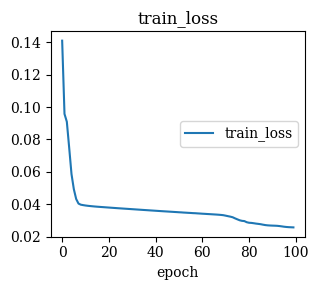

train_loss
	train_loss       	 (min:    0.026, max:    0.141, cur:    0.026)
Epoch 99, Loss: 0.026590948924422264


In [10]:
### Check for available GPUs
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

### Create a DataLoader
train_loader = DataLoader(train_streams, batch_size=32, shuffle=False)

### Initialize the model, optimizer, and loss function
model = GCN(num_node_features=6, hidden_channels=64, num_classes=2)
model = model.to(device) # move onto the GPU
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()
liveloss = PlotLosses(figsize=(6, 3)) 

### Training loop
model.train()
for epoch in range(100):
    logs = {}
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        
        ### Move the batch onto the GPU
        batch = batch.to(device)
        
        out = model(batch.x, batch.edge_index)
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    loss_per_batch = total_loss / len(train_loader)
    logs['train_loss'] = loss_per_batch
    
    liveloss.update(logs)
    
    liveloss.send()
    print(f'Epoch {epoch}, Loss: {loss.item()}')

# Evaluate on test streams

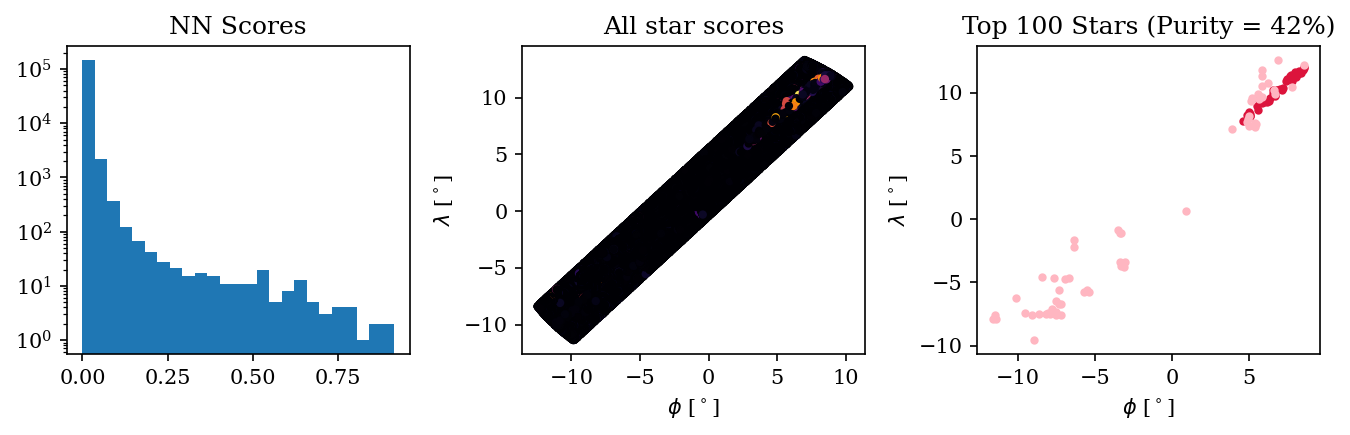

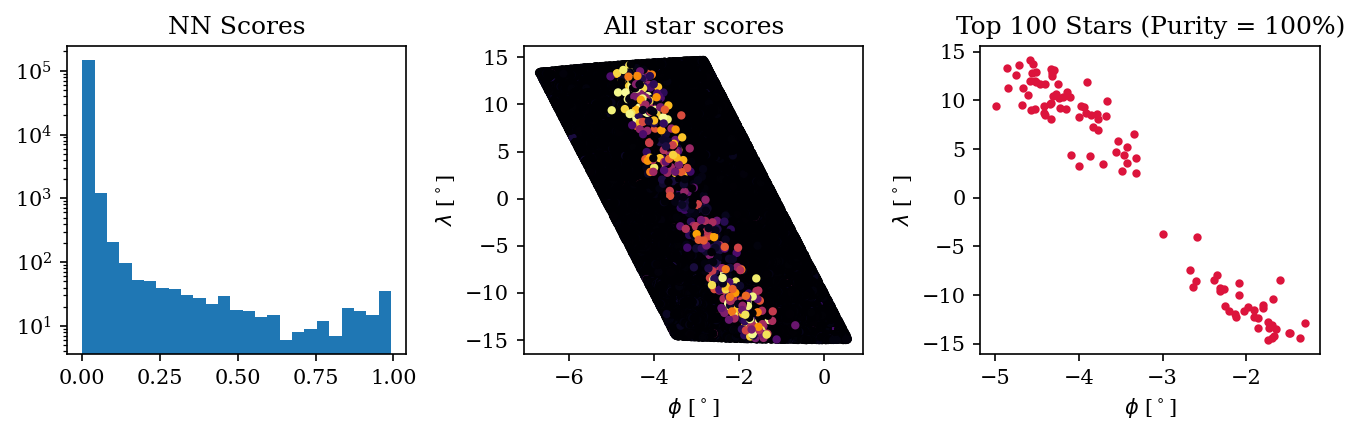

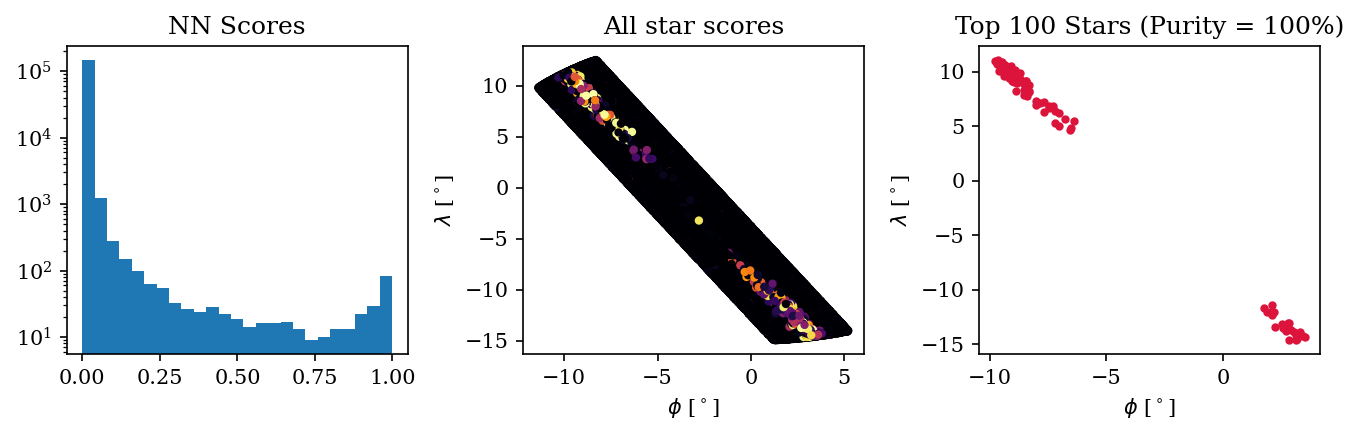

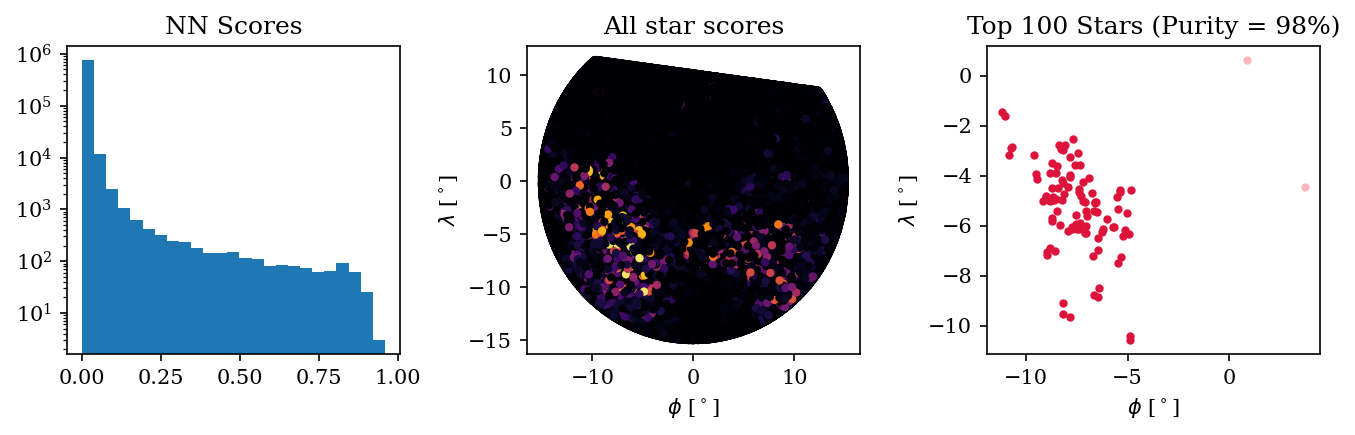

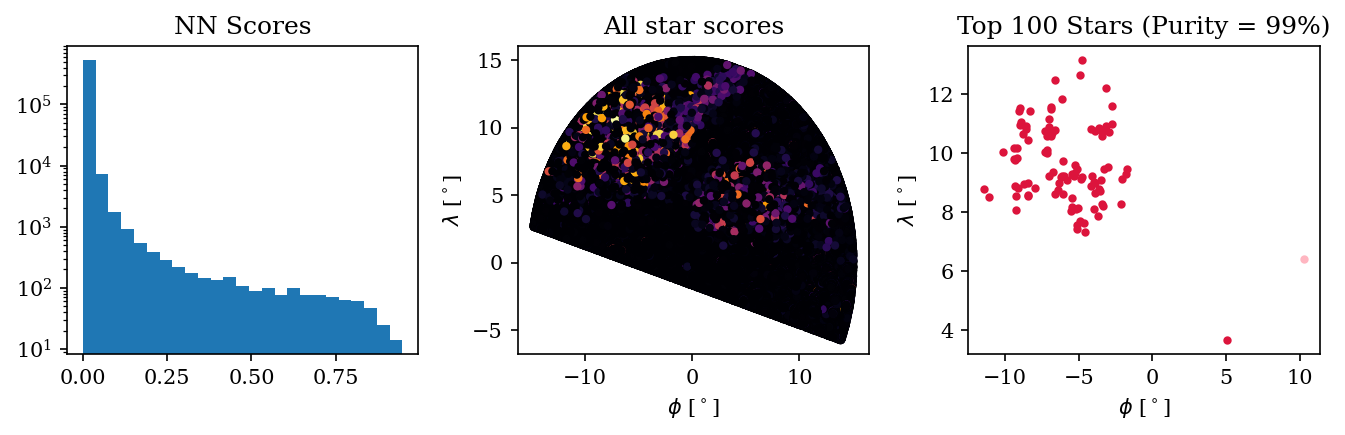

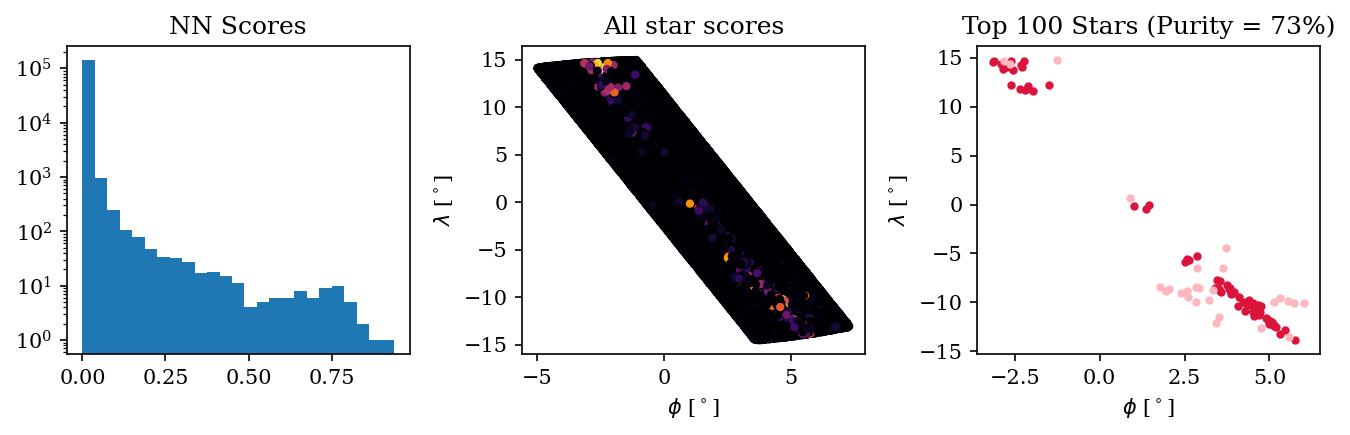

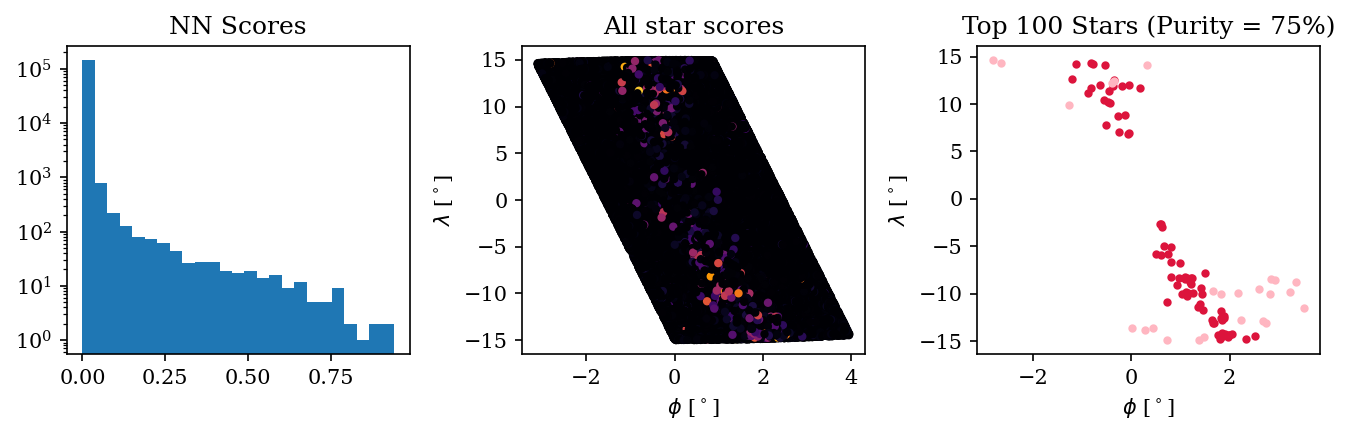

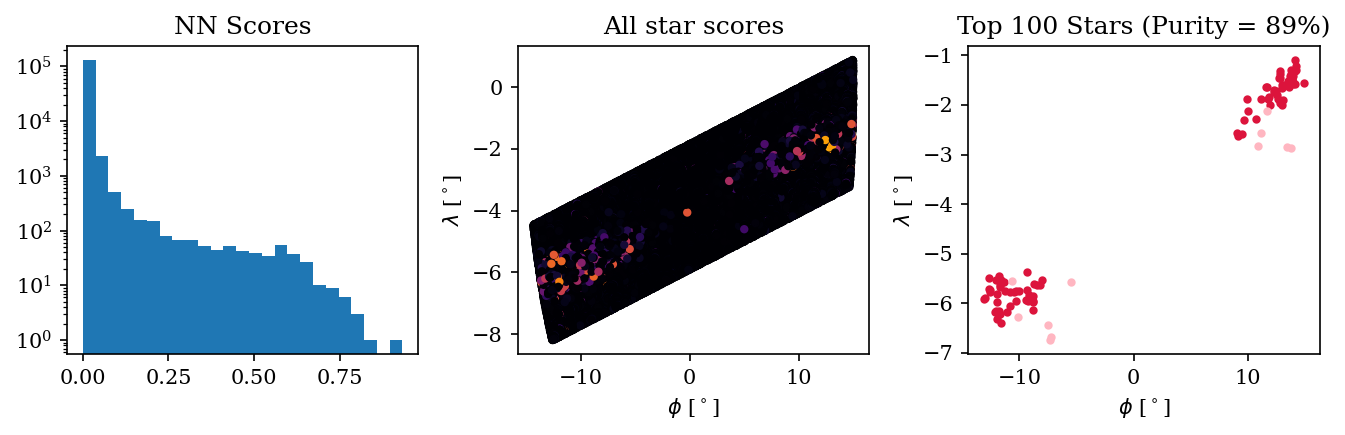

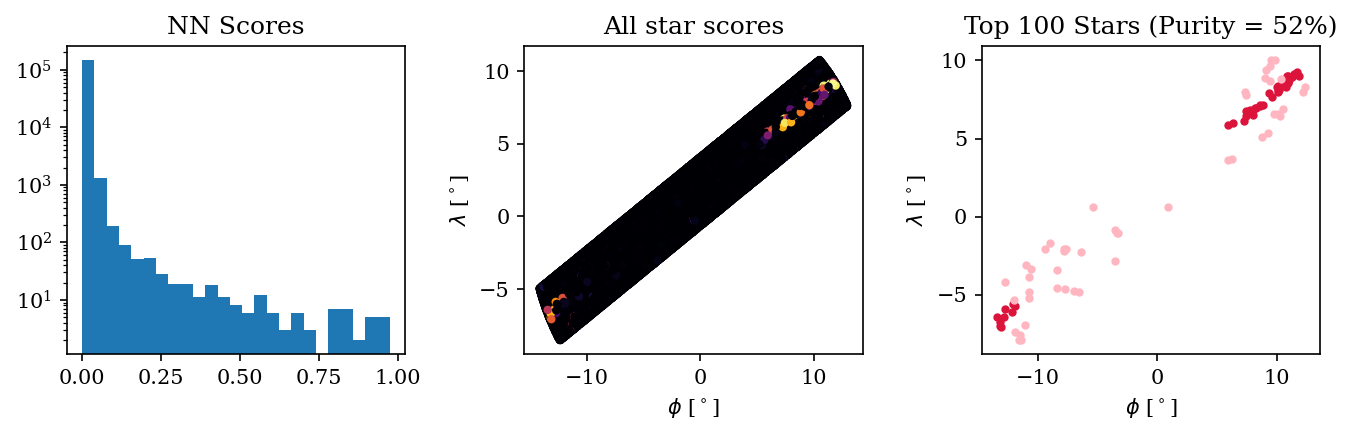

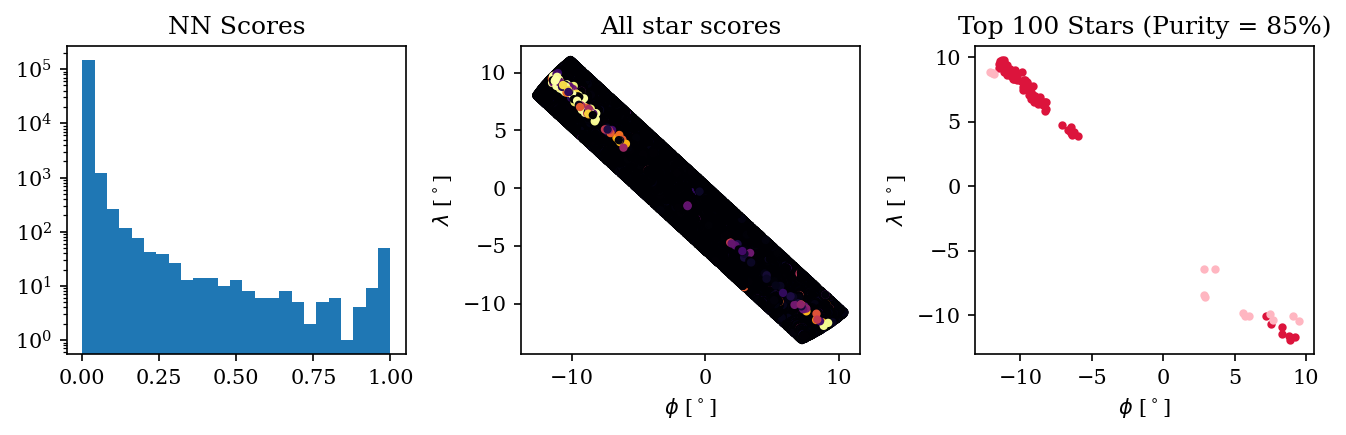

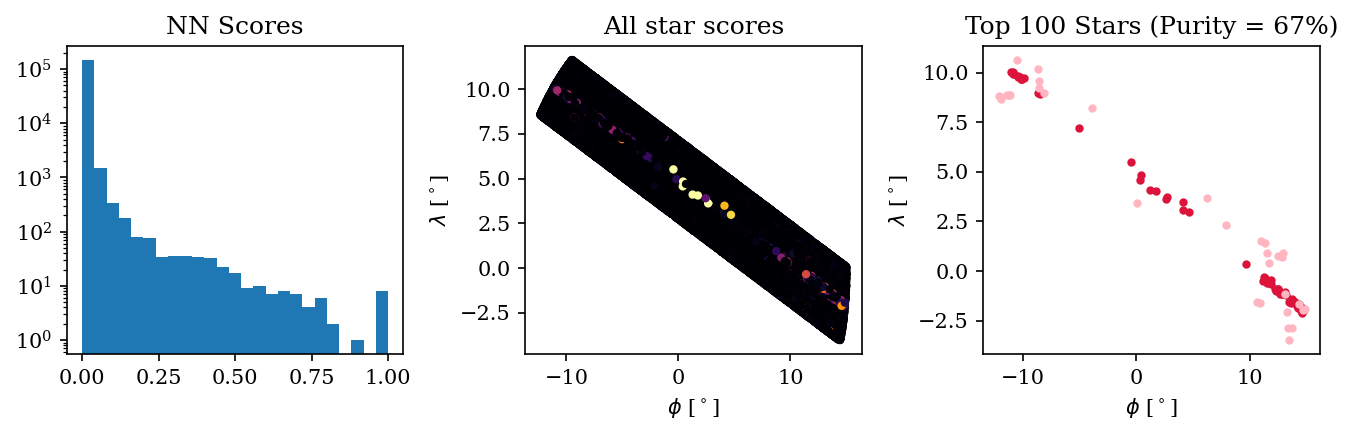

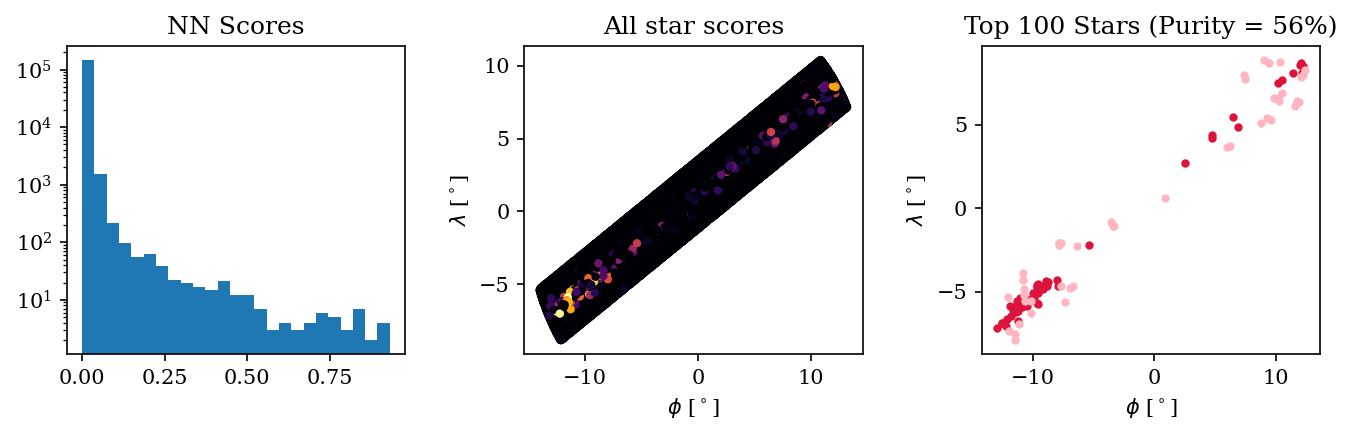

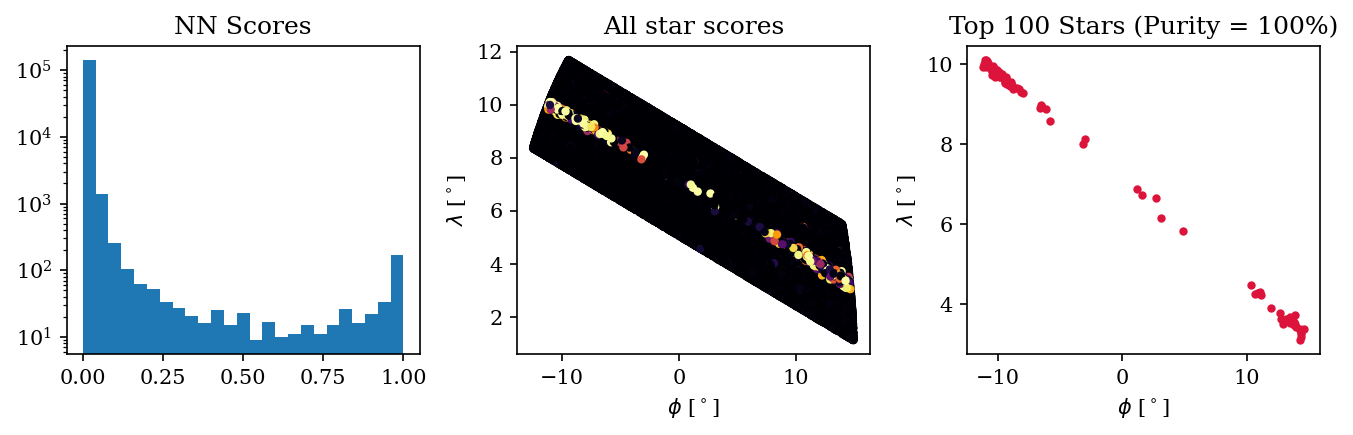

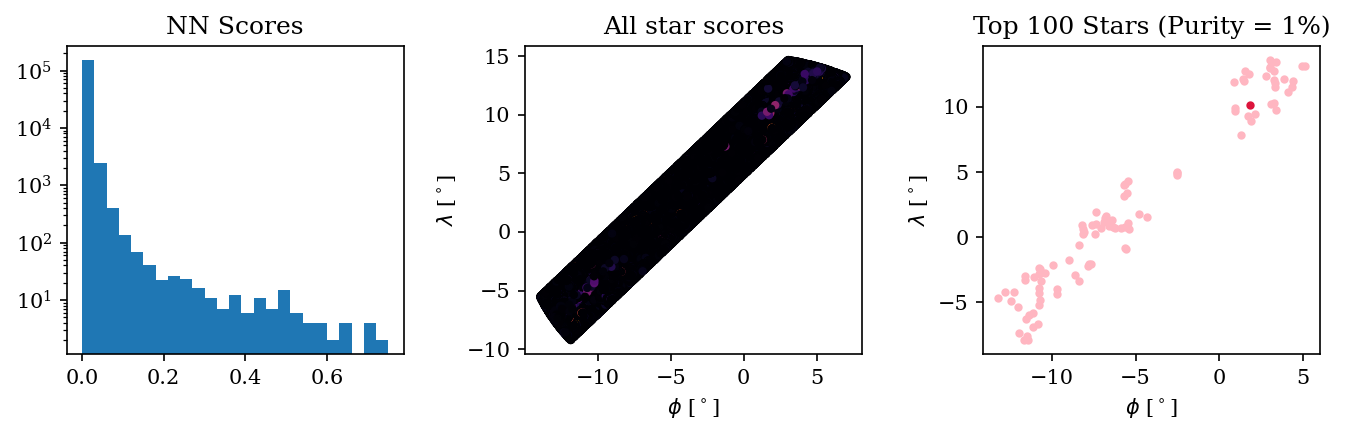

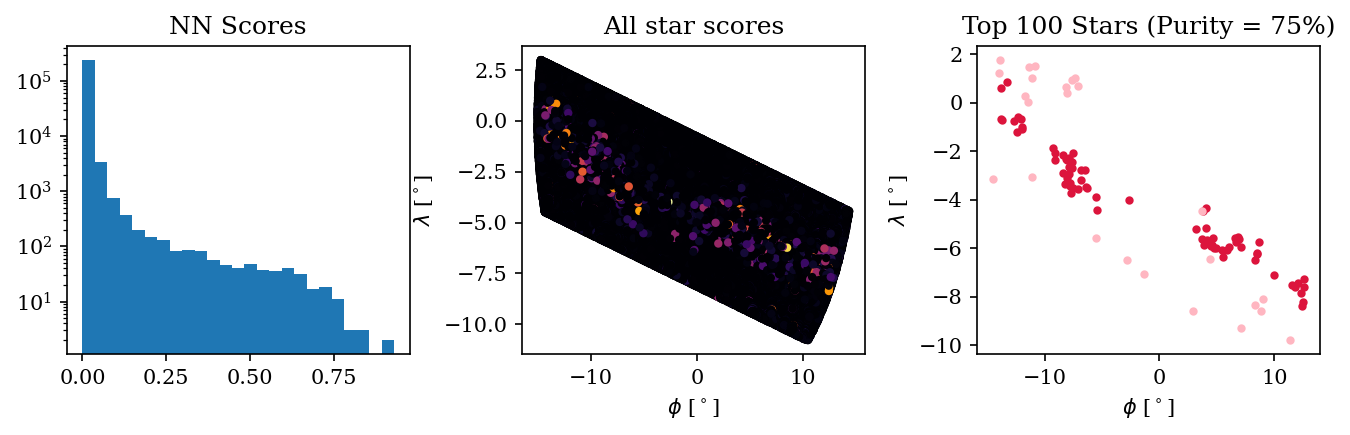

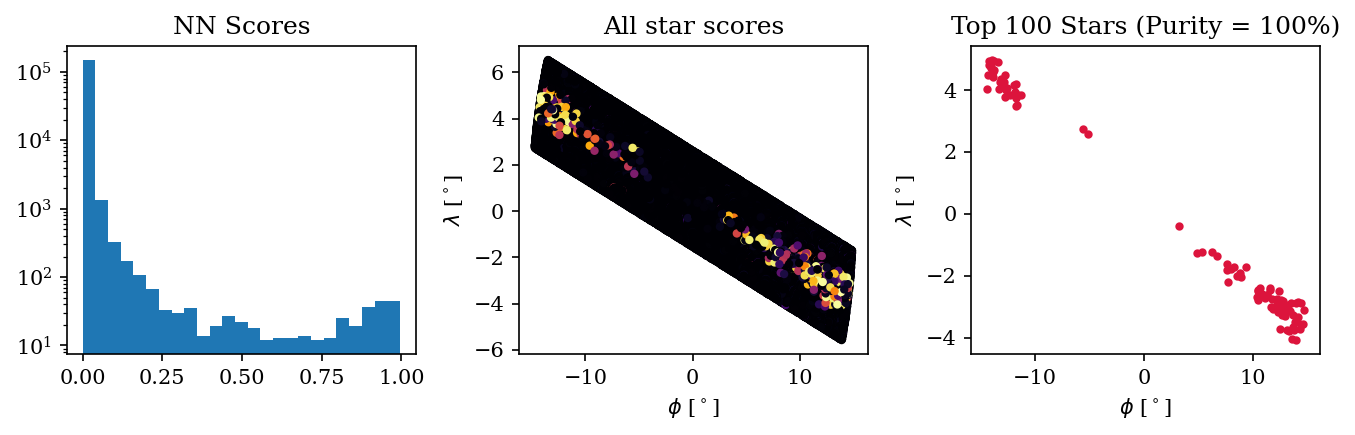

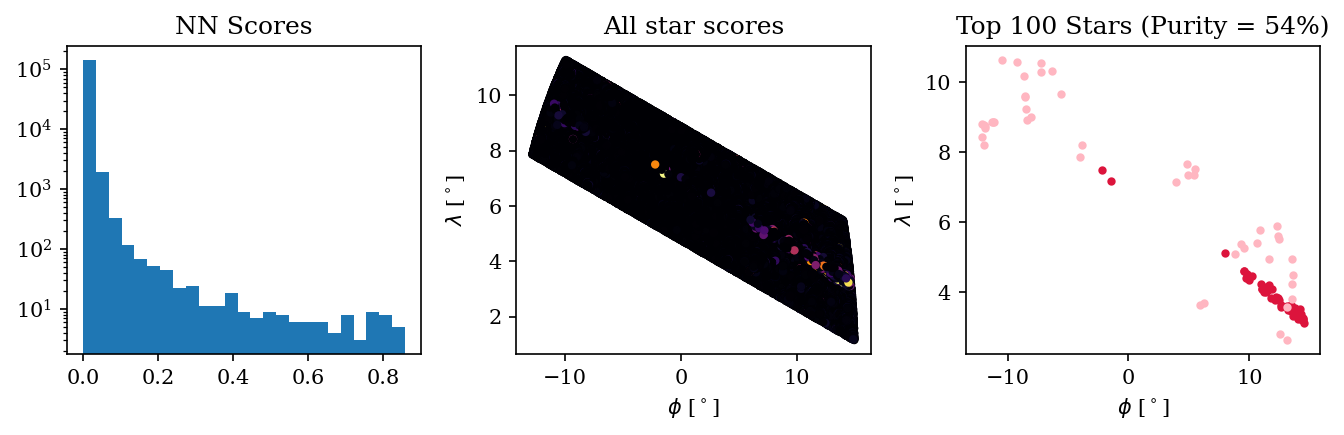

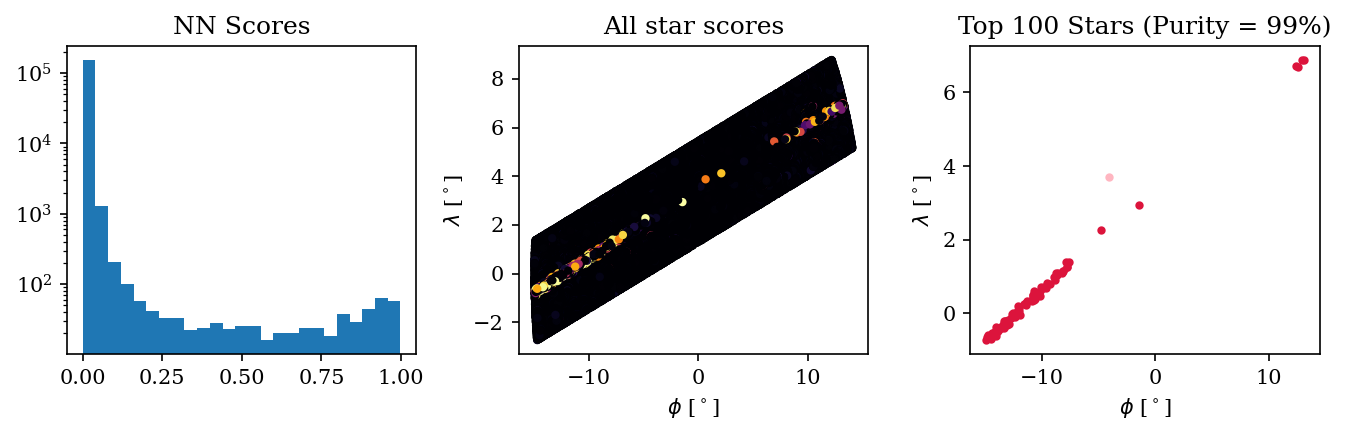

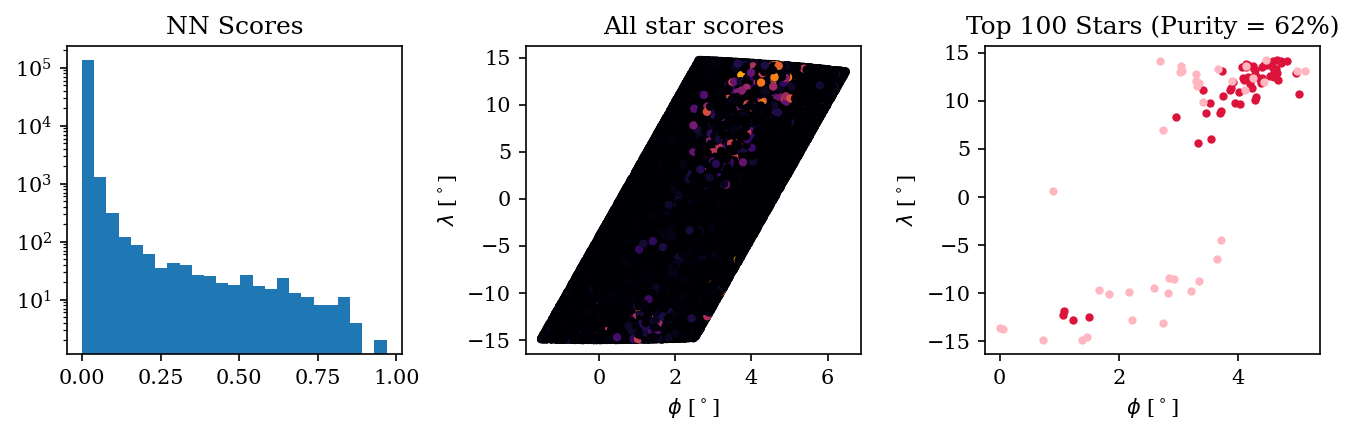

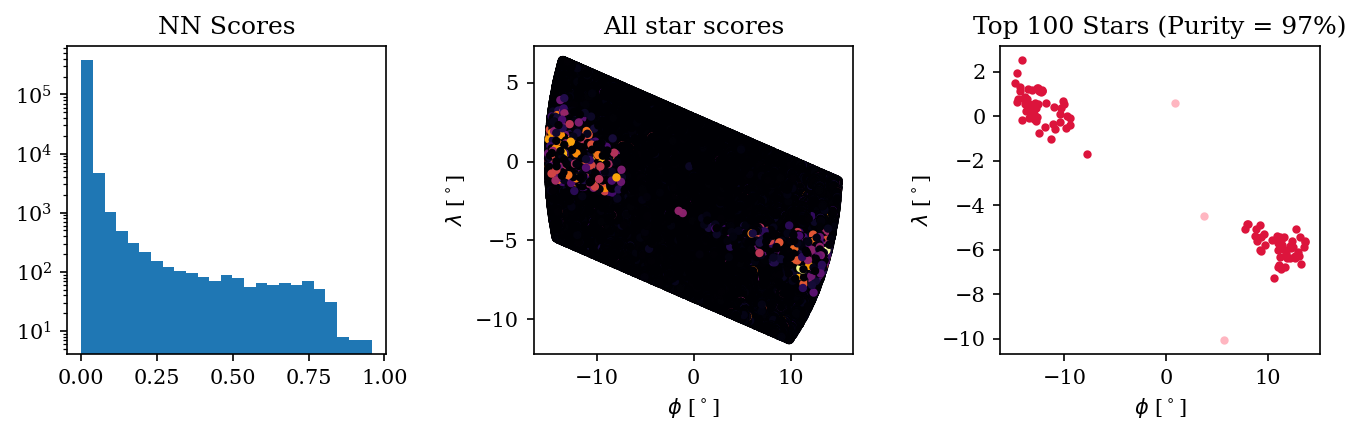

Median purity across all 20 test streams is 80%.


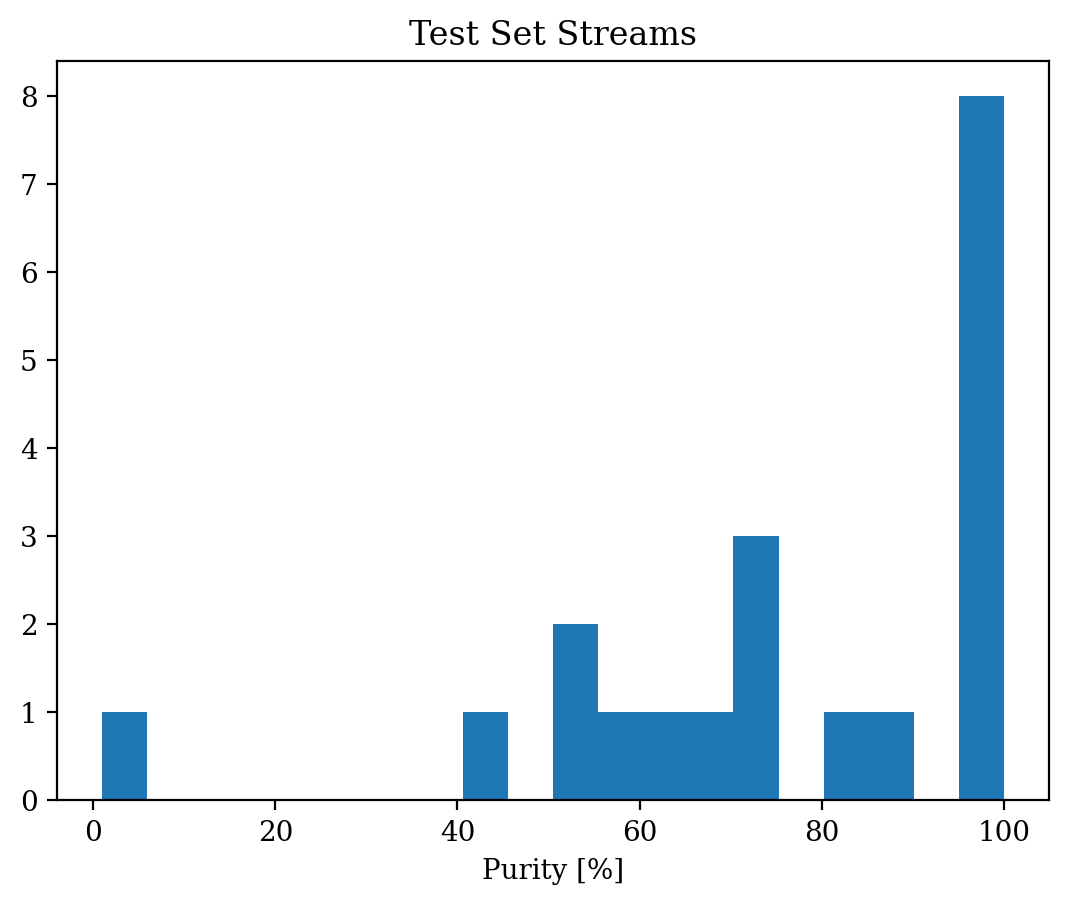

In [11]:
make_plots = True 

test_loader = DataLoader(test_streams, batch_size=1, shuffle=False) # one stream at a time
model.eval()
purities = []

for batch in test_loader:
    ### Move the batch onto the GPU
    batch = batch.to(device)
    
    # print(batch)
    df = pd.DataFrame(batch.x.cpu().detach().numpy(), columns=["ϕ", "λ", "μ_ϕcosλ", "μ_λ", 'b-r', 'g'])
    df["stream"] = batch.y.cpu().detach().numpy().astype("bool")
    out = model(batch.x, batch.edge_index)
    df["nn_score"] = out.softmax(dim=1)[:,1].cpu().detach().numpy() # probability that the star is part of a stream

    if make_plots: 
        fig, axs = plt.subplots(dpi=150, ncols=3, figsize=(9,3), tight_layout=True)
        axs[0].hist(df.nn_score, bins=25);
        axs[0].set_yscale("log")
        axs[0].set_title("NN Scores");
    
        axs[1].scatter(df["ϕ"], df["λ"], c=df.nn_score, cmap="inferno", marker=".");
        axs[1].set_title("All star scores");
        axs[1].set_xlabel(r"$\phi$ [$^\circ$]")
        axs[1].set_ylabel(r"$\lambda$ [$^\circ$]");

    top_stars = df.sort_values('nn_score',ascending=False)[:100]
    try:
        n_perfect_matches = top_stars.stream.value_counts()[True]
        purity = n_perfect_matches/len(top_stars)*100
    except:
        purity = 0
    purities.append(purity)
    
    if make_plots: 
        axs[2].scatter(top_stars[top_stars.stream]["ϕ"], top_stars[top_stars.stream]["λ"], color="crimson", marker=".");
        axs[2].scatter(top_stars[~top_stars.stream]["ϕ"], top_stars[~top_stars.stream]["λ"], color="lightpink", marker=".");
        axs[2].set_xlabel(r"$\phi$ [$^\circ$]")
        axs[2].set_ylabel(r"$\lambda$ [$^\circ$]");
        axs[2].set_title(f"Top 100 Stars (Purity = {purity:.0f}%)");

    plt.show()
    plt.close()

plt.figure(dpi=200)
plt.hist(purities, bins=20);
plt.xlabel("Purity [%]");
plt.title("Test Set Streams");
print(f"Median purity across all {len(test_loader)} test streams is {np.median(purities):.0f}%.")

### Important Note: Why This Purity-Based Evaluation Is Misleading

This block computes **purity** (TP / (TP + FP)) after artificially reducing the number of stream stars (`signal`) at the **analysis** stage — meaning the model still runs on the **full graph**, including all stream stars, and only afterward do we subsample them.

This logic is flawed if we are trying to demonstrate that **model performance remains stable as signal presence drops**, because:

- The **model has access to all stream stars during inference**, regardless of how many we sample afterward.
- The **NN score distribution is influenced by the full signal structure**, so reducing labels post hoc doesn't reduce the model's ability to detect the stream.
- Therefore, the purity score **does not fairly reflect how the model would perform with limited signal presence** during both training and inference.

To properly benchmark the model’s robustness to lower signal fractions, we should:
1. **Remove stream stars entirely from the graph before inference**, not just from the labels.
2. **Use metrics like ROC AUC and SIC**, which are not as sensitive to class imbalance as purity.

> This current block is useful for a coarse check but **does not show true robustness under limited signal** and can misleadingly suggest performance stability.



Evaluating 20% stream injection


100%|██████████| 20/20 [00:00<00:00, 23.89it/s]


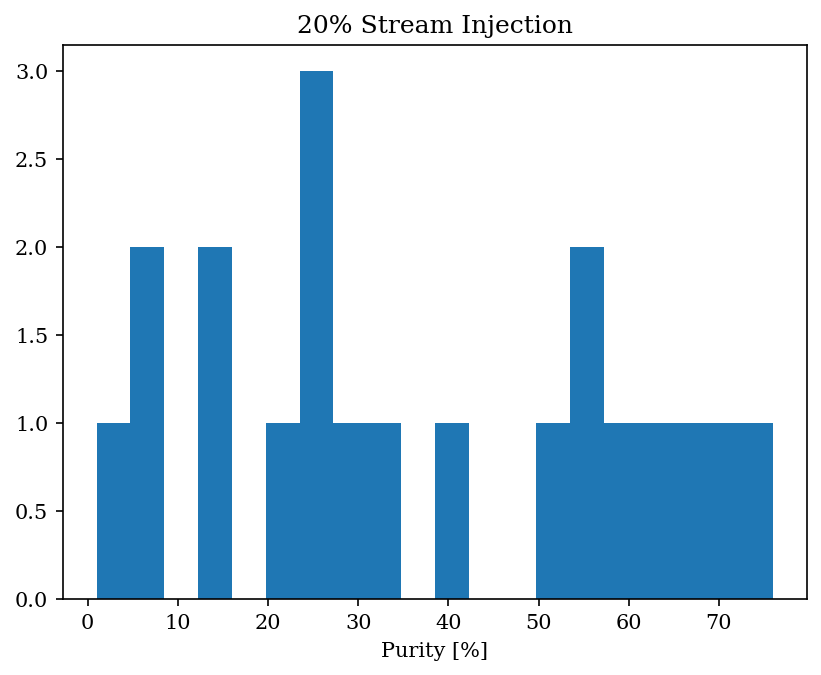

Median purity: 30.5%

Evaluating 60% stream injection


100%|██████████| 20/20 [00:00<00:00, 25.75it/s]


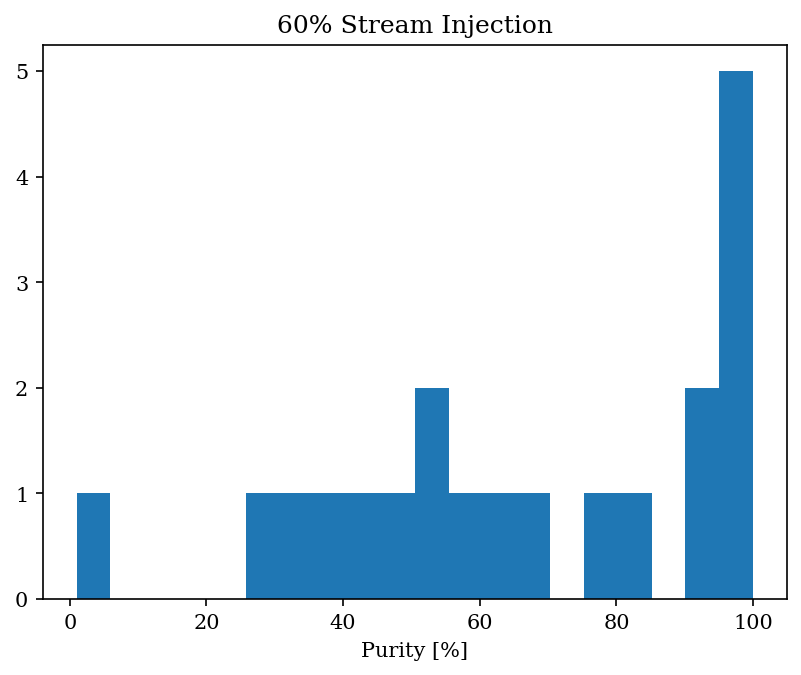

Median purity: 65.0%

Evaluating 80% stream injection


100%|██████████| 20/20 [00:00<00:00, 25.82it/s]


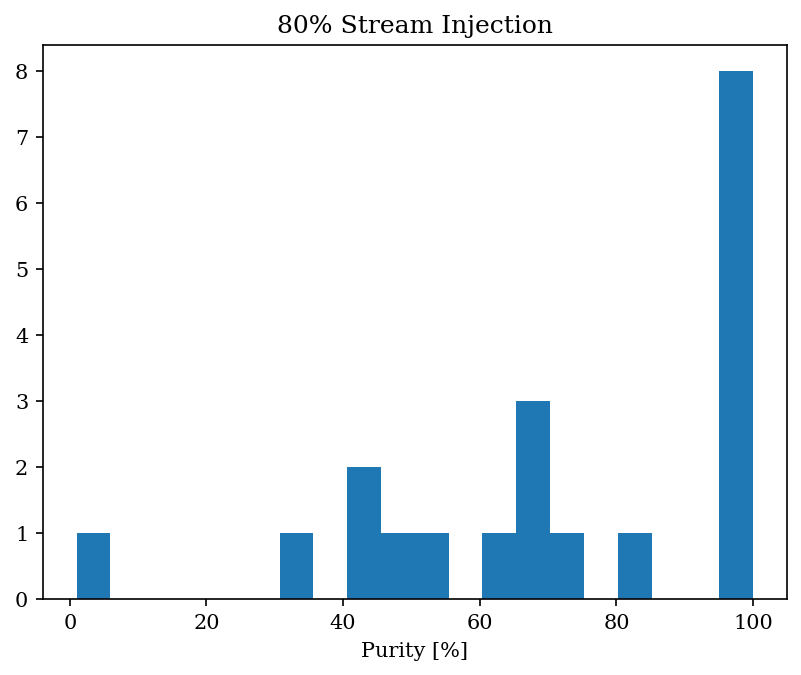

Median purity: 71.0%

Evaluating 100% stream injection


100%|██████████| 20/20 [00:00<00:00, 25.94it/s]


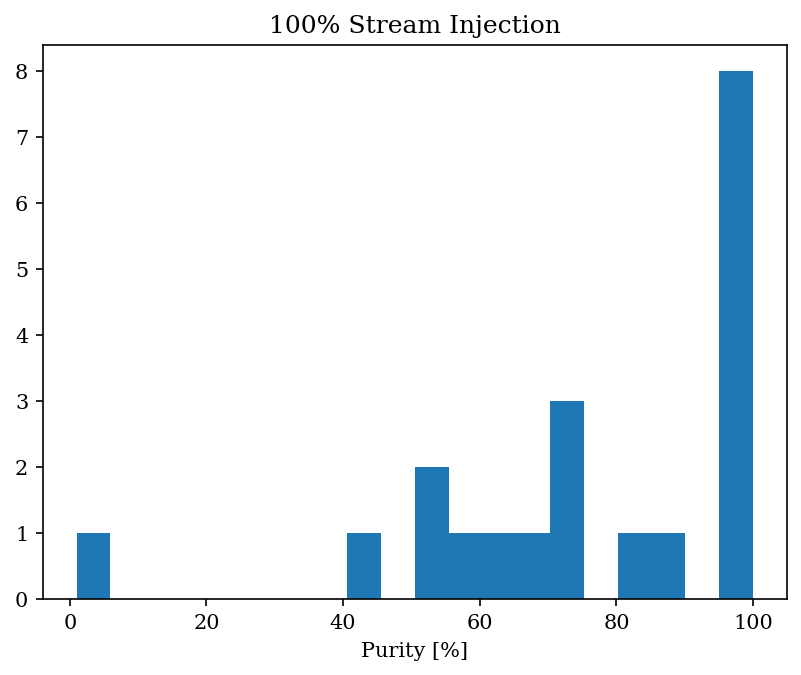

Median purity: 80.0%

Evaluating 20% stream injection


100%|██████████| 20/20 [00:00<00:00, 26.07it/s]


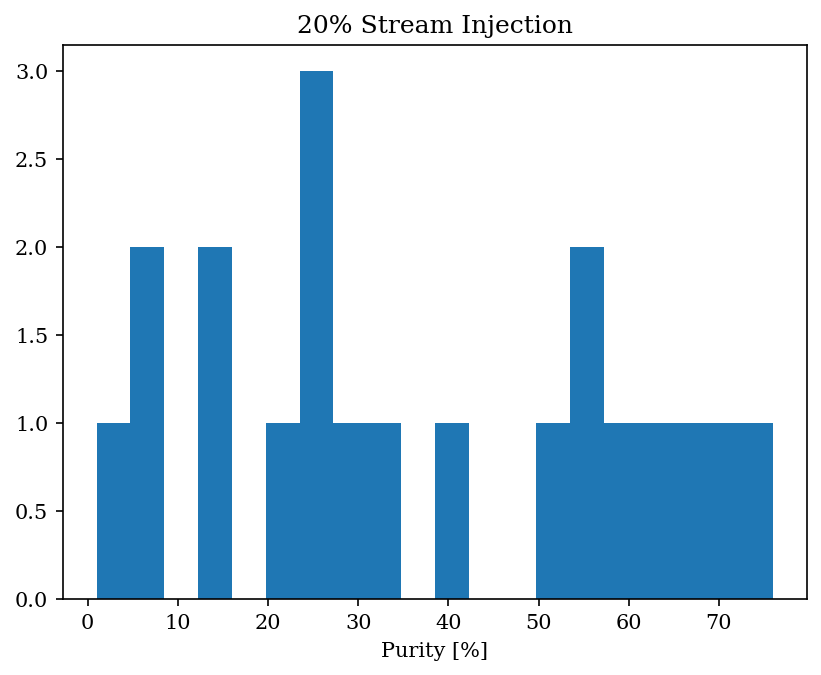

Median purity: 30.5%

Evaluating 60% stream injection


100%|██████████| 20/20 [00:00<00:00, 25.92it/s]


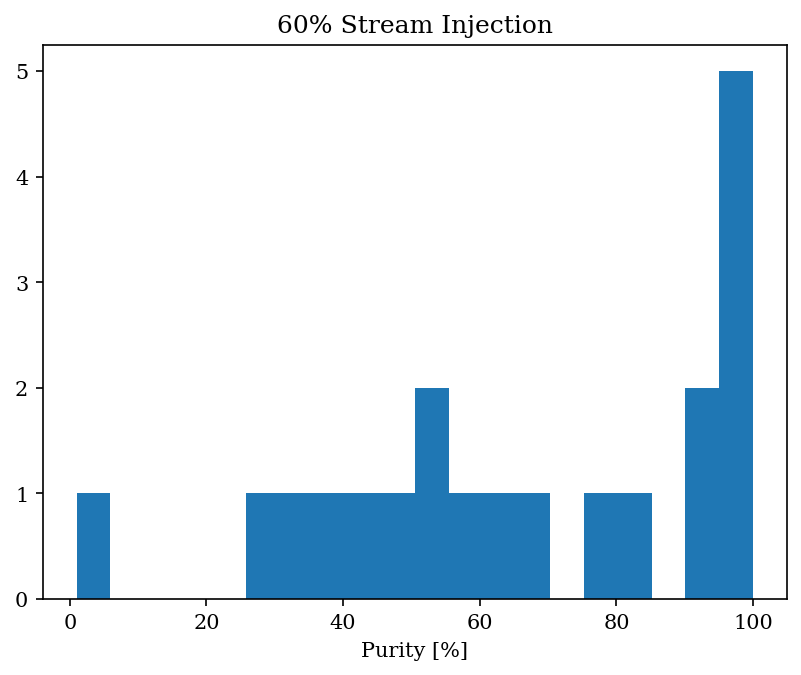

Median purity: 65.0%

Evaluating 80% stream injection


100%|██████████| 20/20 [00:00<00:00, 25.79it/s]


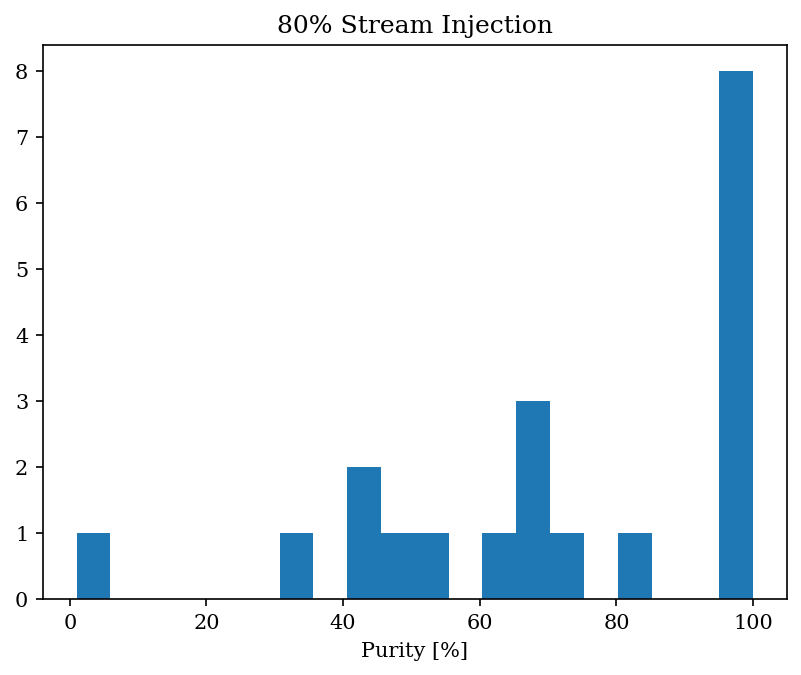

Median purity: 71.0%

Evaluating 100% stream injection


100%|██████████| 20/20 [00:00<00:00, 25.88it/s]


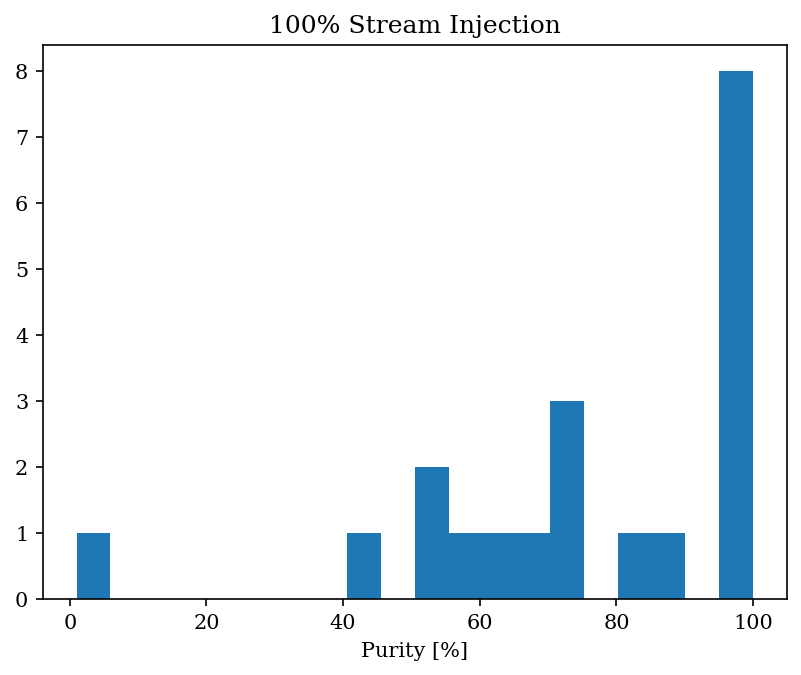

Median purity: 80.0%


In [12]:
torch.manual_seed(42)
np.random.seed(42)

stream_percentages = [0.2, 0.6, 0.8, 1.0]
model.eval()
purity_results = {}

for perc in stream_percentages:
    print(f"\nEvaluating {int(perc * 100)}% stream injection")
    purities = []

    for batch in tqdm(test_streams):  # batch is a full graph
        batch = batch.to(device)
        x, edge_index, y = batch.x, batch.edge_index, batch.y

        # Run model on the full graph
        out = model(x, edge_index)
        nn_scores = out.softmax(dim=1)[:, 1].cpu().detach().numpy()

        # Build dataframe for analysis
        df = pd.DataFrame(x.cpu().numpy(), columns=["ϕ", "λ", "μ_ϕcosλ", "μ_λ", 'b-r', 'g'])
        df["stream"] = y.cpu().numpy().astype(bool)
        df["nn_score"] = nn_scores

        # --- Simulate stream injection at the *analysis* level ---
        full_stream_df = df[df["stream"]]
        bkg_df = df[~df["stream"]]

        n_keep = int(len(full_stream_df) * perc)
        if n_keep == 0:
            purities.append(0)
            continue

        sampled_stream_df = full_stream_df.sample(n=n_keep, random_state=42)
        reduced_df = pd.concat([sampled_stream_df, bkg_df], ignore_index=True)

        # Sort by NN score and compute purity
        top_stars = reduced_df.sort_values("nn_score", ascending=False).head(100)
        try:
            n_correct = top_stars["stream"].value_counts()[True]
            purity = n_correct / len(top_stars) * 100
        except:
            purity = 0
        purities.append(purity)

    purity_results[perc] = purities
    plt.figure(dpi=150)
    plt.hist(purities, bins=20)
    plt.xlabel("Purity [%]")
    plt.title(f"{int(perc * 100)}% Stream Injection")
    plt.show()

    print(f"Median purity: {np.median(purities):.1f}%")

stream_percentages = [0.2, 0.6, 0.8, 1.0]
model.eval()
purity_results = {}

for perc in stream_percentages:
    print(f"\nEvaluating {int(perc * 100)}% stream injection")
    purities = []

    for batch in tqdm(test_streams):  # batch is a full graph
        batch = batch.to(device)
        x, edge_index, y = batch.x, batch.edge_index, batch.y

        # Run model on the full graph
        out = model(x, edge_index)
        nn_scores = out.softmax(dim=1)[:, 1].cpu().detach().numpy()

        # Build dataframe for analysis
        df = pd.DataFrame(x.cpu().numpy(), columns=["ϕ", "λ", "μ_ϕcosλ", "μ_λ", 'b-r', 'g'])
        df["stream"] = y.cpu().numpy().astype(bool)
        df["nn_score"] = nn_scores

        # --- Simulate stream injection at the *analysis* level ---
        full_stream_df = df[df["stream"]]
        bkg_df = df[~df["stream"]]

        n_keep = int(len(full_stream_df) * perc)
        if n_keep == 0:
            purities.append(0)
            continue

        sampled_stream_df = full_stream_df.sample(n=n_keep, random_state=42)
        reduced_df = pd.concat([sampled_stream_df, bkg_df], ignore_index=True)

        # Sort by NN score and compute purity
        top_stars = reduced_df.sort_values("nn_score", ascending=False).head(100)
        try:
            n_correct = top_stars["stream"].value_counts()[True]
            purity = n_correct / len(top_stars) * 100
        except:
            purity = 0
        purities.append(purity)

    purity_results[perc] = purities
    plt.figure(dpi=150)
    plt.hist(purities, bins=20)
    plt.xlabel("Purity [%]")
    plt.title(f"{int(perc * 100)}% Stream Injection")
    plt.show()

    print(f"Median purity: {np.median(purities):.1f}%")


### Why This Method Is Correct

This approach evaluates how a **supervised model's performance changes** as the fraction of stream stars is reduced in the **input graph**, while keeping the full background intact. This tests whether the model is robust to weaker signal injection without introducing artificial purity artifacts.

---

#### 🔍 What It Does

- **True stream removal**: Instead of masking labels or altering the dataframe after inference, this method actually **removes stream nodes from the graph before the model sees them**.
  - Stream star features are excluded
  - Their edges are also removed, so the **graph structure is modified**
- **Edge reindexing**: Because node indices change after filtering, the edge list is **remapped** so the model receives a valid subgraph.
- **Performance metrics**:
  - **ROC Curve**: Measures model discrimination power
  - **AUC Score**: Summarizes the ROC into a single number
  - **SIC Curve**: Plots TPR / √FPR 
  - **NN Score Distributions**: Shows confidence shift at each stream level

---

#### Final Goal

This tests the model's **true robustness to decreasing signal fraction**. A well-trained supervised model should maintain performance (e.g. AUC, SIC) even as fewer signal events are present — and this method accurately reflects that.



100%|██████████| 20/20 [02:05<00:00,  6.28s/it]


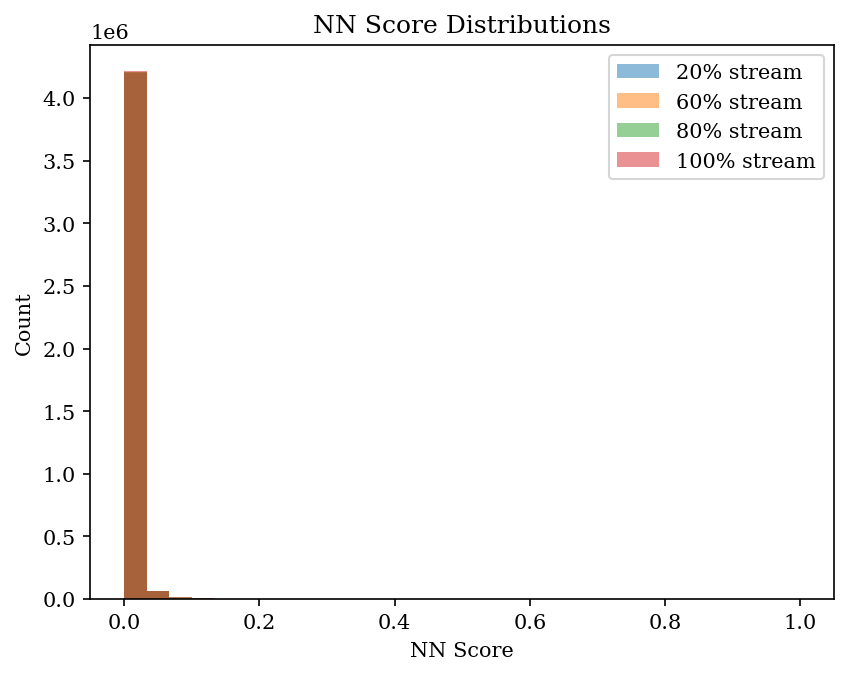

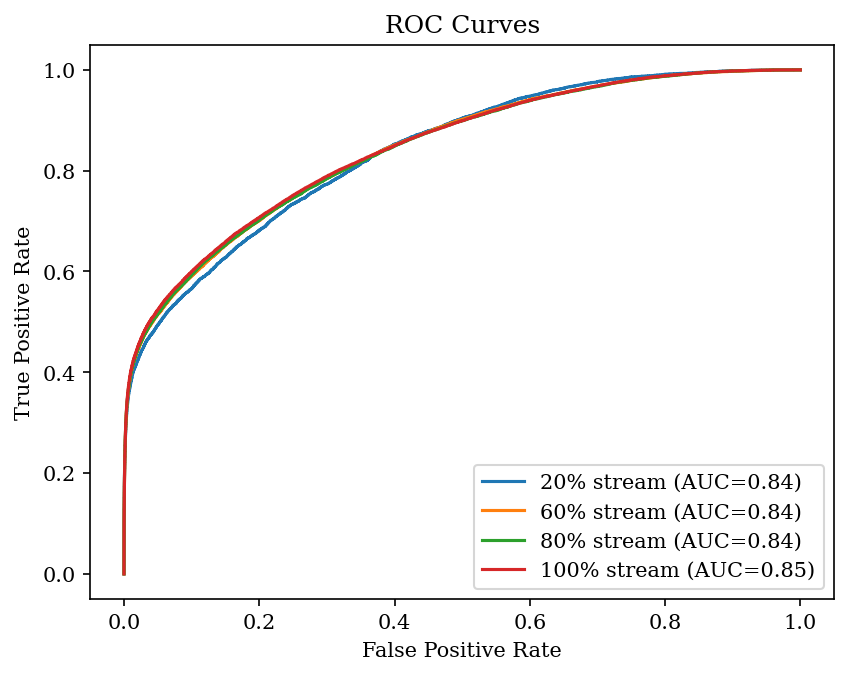

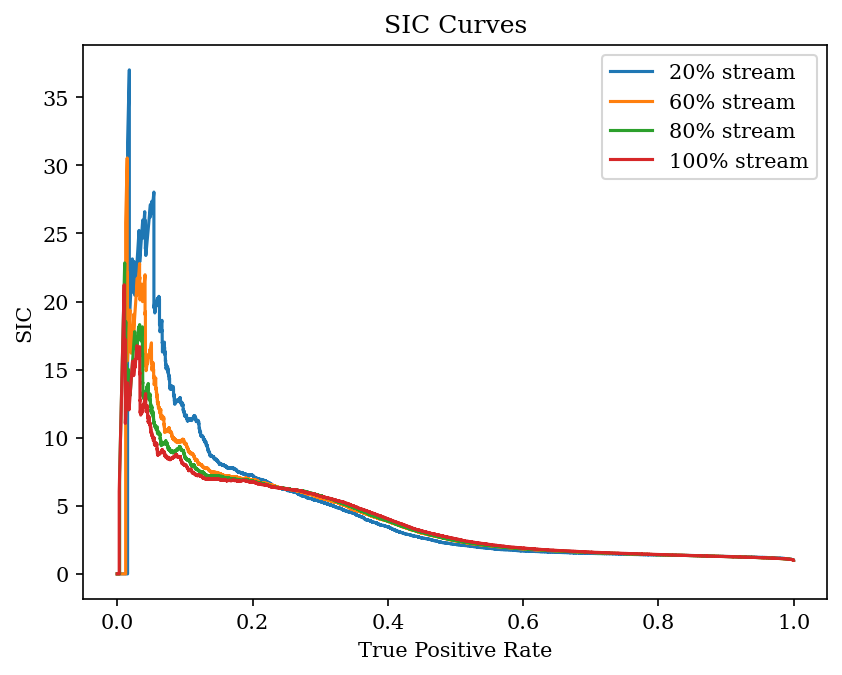

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

torch.manual_seed(42)
np.random.seed(42)

stream_percentages = [0.2, 0.6, 0.8, 1.0]
model.eval()

# Store results
sic_curves = {}
roc_curves = {}
auc_scores = {}
score_distributions = {}

for perc in stream_percentages:
    y_true_all = []
    y_score_all = []

    for batch in tqdm(test_streams):
        batch = batch.to(device)
        x, edge_index, y = batch.x, batch.edge_index, batch.y

        stream_idx = (y == 1).nonzero(as_tuple=True)[0]
        bkg_idx = (y == 0).nonzero(as_tuple=True)[0]

        n_stream = int(len(stream_idx) * perc)
        if n_stream == 0 or len(stream_idx) == 0:
            continue

        keep_stream_idx = np.random.choice(stream_idx.cpu(), size=n_stream, replace=False)
        keep_stream_idx = torch.tensor(keep_stream_idx, dtype=torch.long, device=device)

        # Combine with all background stars
        final_indices = torch.cat([bkg_idx, keep_stream_idx])
        final_indices_sorted, _ = torch.sort(final_indices)

        # Remap edge index
        index_map = {old.item(): new for new, old in enumerate(final_indices_sorted)}

        mask = torch.isin(edge_index[0], final_indices_sorted) & torch.isin(edge_index[1], final_indices_sorted)
        edge_sub = edge_index[:, mask]

        edge_remapped = torch.stack([
            torch.tensor([index_map[i.item()] for i in edge_sub[0].cpu()], dtype=torch.long),
            torch.tensor([index_map[i.item()] for i in edge_sub[1].cpu()], dtype=torch.long)
        ]).to(device)

        # Slice data
        x_sub = x[final_indices_sorted]
        y_sub = y[final_indices_sorted]

        # Forward pass
        out = model(x_sub, edge_remapped)
        y_score = out.softmax(dim=1)[:, 1].detach().cpu().numpy()
        y_label = y_sub.detach().cpu().numpy()

        y_true_all.extend(y_label)
        y_score_all.extend(y_score)

    # Compute metrics
    fpr, tpr, thresholds = roc_curve(y_true_all, y_score_all)
    auc = roc_auc_score(y_true_all, y_score_all)
    with np.errstate(divide='ignore', invalid='ignore'):
        sic = np.divide(tpr, np.sqrt(fpr))
        sic[np.isnan(sic)] = 0
        sic[np.isinf(sic)] = 0

    # Save
    sic_curves[perc] = (tpr, sic)
    roc_curves[perc] = (fpr, tpr)
    auc_scores[perc] = auc
    score_distributions[perc] = y_score_all

# Plot NN score distributions
plt.figure(dpi=150)
for perc in stream_percentages:
    plt.hist(score_distributions[perc], bins=30, alpha=0.5, label=f"{int(perc*100)}% stream")
plt.xlabel("NN Score")
plt.ylabel("Count")
plt.title("NN Score Distributions")
plt.legend()
plt.show()

# Plot ROC curves
plt.figure(dpi=150)
for perc in stream_percentages:
    fpr, tpr = roc_curves[perc]
    auc = auc_scores[perc]
    plt.plot(fpr, tpr, label=f"{int(perc*100)}% stream (AUC={auc:.2f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.show()

# Plot SIC curves
plt.figure(dpi=150)
for perc in stream_percentages:
    tpr, sic = sic_curves[perc]
    plt.plot(tpr, sic, label=f"{int(perc*100)}% stream")
plt.xlabel("True Positive Rate")
plt.ylabel("SIC")
plt.title("SIC Curves")
plt.legend()
plt.show()
